1.Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

2. Data preprocessing

In [2]:

# بارگذاری داده‌ها
dataset_path = 'C:/Users/Ro0ak/Desktop/dataAruba1.csv'
data = pd.read_csv(dataset_path, delimiter=',', header=None, names=['Date', 'Time', 'Sensor ID', 'State', 'Activity Label', 'Start/End'])

# پیش‌پردازش ستون "State"
def preprocess_state(row):
    sensor_id = row['Sensor ID']
    state = row['State']
    
    if sensor_id.startswith('M') or sensor_id.startswith('D'):
        if state in ['ON', 'OPEN']:
            return 1.0
        elif state in ['OFF', 'CLOSE']:
            return 0.0
    elif sensor_id.startswith('T'):
        try:
            return float(state)
        except ValueError:
            return np.nan
    return np.nan



data['State'] = data.apply(preprocess_state, axis=1)

# پر کردن مقادیر خالی برای حسگرهای دما
data['State'] = data.groupby(data['Sensor ID'].str.startswith('T'))['State'].transform(lambda x: x.fillna(x.mean()))

# پر کردن مقادیر خالی
data['Activity Label'] = data['Activity Label'].fillna('No Activity')
data['Start/End'] = data['Start/End'].fillna('None')

# پر کردن "Activity Label" بر اساس "Start/End"
current_activity = 'No Activity'
for index, row in data.iterrows():
    if row['Start/End'] == 'begin':
        current_activity = row['Activity Label']
    elif row['Start/End'] == 'end':
        current_activity = 'No Activity'
    data.at[index, 'Activity Label'] = current_activity

print(data.head())


# پیش‌پردازش ستون "Sensor ID"
def preprocess_sensor_id(sensor_id):
    if sensor_id.startswith('M'):
        return 1  # حسگر حرکتی
    elif sensor_id.startswith('D'):
        return 2  # حسگر درب
    elif sensor_id.startswith('T'):
        return 3  # حسگر دما
    else:
        return 0  # مقدار نامشخص

data['Sensor Numeric ID'] = data['Sensor ID'].apply(preprocess_sensor_id)

# نرمال‌سازی مقادیر "Sensor Numeric ID"
scaler = StandardScaler()
data['Sensor Numeric ID'] = scaler.fit_transform(data[['Sensor Numeric ID']])

# ایجاد پنجره‌ها با ویژگی‌های متعدد
def create_sliding_windows_with_features(data, window_size, step_size):
    windows = []
    labels = []
    features = ['State', 'Sensor Numeric ID']  # ویژگی‌های انتخاب‌شده
    
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end][features].values  # انتخاب چندین ویژگی
        windows.append(window)
        labels.append(data.iloc[end - 1]['Activity Label'])  # انتخاب برچسب فعالیت
    
    return windows, labels

window_size = 10  # اندازه پنجره
step_size = 1  # گام پنجره

windows, labels = create_sliding_windows_with_features(data, window_size, step_size)

# تبدیل پنجره‌ها به تنسورهای PyTorch
window_tensors = [torch.tensor(window, dtype=torch.float32) for window in windows]

# پد کردن (Pad) توالی‌ها به طول ثابت
max_len = max(len(t) for t in window_tensors)
padded_sequences = [F.pad(t, (0, 0, 0, max_len - len(t))) for t in window_tensors]

# تبدیل تنسورها به آرایه‌های Numpy
X = np.stack([t.numpy() for t in padded_sequences])

# تبدیل برچسب‌ها به اعداد
label_to_index = {label: idx for idx, label in enumerate(set(labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
y = np.array([label_to_index[label] for label in labels])

# اطلاعات نهایی داده‌ها
print("Final preprocessed data shape:", X.shape)
print("Final labels shape:", y.shape)
print("Number of unique labels:", len(label_to_index))
print("Sample label mapping:", label_to_index)

# نمایش چند نمونه از داده‌های پنجره‌گذاری شده و برچسب‌ها
print(f"Sample window data:\n{X[0]}")
print(f"Sample labels:\n{y[:5]}")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CPC model
class CPCModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CPCModel, self).__init__()
        self.encoder = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.predictor = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        encoded, _ = self.encoder(x)
        output, _ = self.gru(encoded)
        predictions = self.predictor(output)
        return predictions

# Initialize the CPC model
input_dim = X.shape[2]  # Number of features
hidden_dim = 128
output_dim = len(label_to_index)  # Number of unique labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpc_model = CPCModel(input_dim, hidden_dim, output_dim).to(device)

# Define a function to prepare the DataLoader
def prepare_dataloader(X, y, batch_size=64):
    tensor_x = torch.Tensor(X)  # transform to torch tensor
    tensor_y = torch.Tensor(y).long()
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

train_loader = prepare_dataloader(X_train, y_train)
val_loader = prepare_dataloader(X_val, y_val)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cpc_model.parameters(), lr=1e-4)

# Check for CUDA availability and adjust scaler accordingly
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

# Training loop for CPC model
num_epochs = 2
cpc_model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = cpc_model(batch_x)
                # Reshape outputs and batch_y for CrossEntropyLoss
                batch_size, seq_length, _ = outputs.size()
                outputs = outputs.view(-1, output_dim)  # [batch_size * sequence_length, output_dim]
                batch_y = batch_y.repeat(seq_length)  # Repeat batch_y for each sequence step
                batch_y = batch_y.view(-1)  # [batch_size * sequence_length]

                # Compute the loss
                loss = criterion(outputs, batch_y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = cpc_model(batch_x)
            # Reshape outputs and batch_y for CrossEntropyLoss
            batch_size, seq_length, _ = outputs.size()
            outputs = outputs.view(-1, output_dim)  # [batch_size * sequence_length, output_dim]
            batch_y = batch_y.repeat(seq_length)  # Repeat batch_y for each sequence step
            batch_y = batch_y.view(-1)  # [batch_size * sequence_length]

            # Compute the loss
            loss = criterion(outputs, batch_y)

            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


        Date     Time Sensor ID  State Activity Label Start/End
0  11/4/2010  03:50.2      M003    1.0       Sleeping     begin
1  11/4/2010  03:57.4      M003    0.0       Sleeping      None
2  11/4/2010  15:09.0      T002   21.5       Sleeping      None
3  11/4/2010  30:19.2      T003   21.0       Sleeping      None
4  11/4/2010  30:19.4      T004   21.0       Sleeping      None
Final preprocessed data shape: (1048567, 10, 2)
Final labels shape: (1048567,)
Number of unique labels: 12
Sample label mapping: {'No Activity': 0, 'Meal_Preparation': 1, 'Sleeping': 2, 'Bed_to_Toilet': 3, 'Wash_Dishes': 4, 'Relax': 5, 'Eating': 6, 'Leave_Home': 7, 'Enter_Home': 8, 'Housekeeping': 9, 'Work': 10, 'Respirate': 11}
Sample window data:
[[ 1.         -0.29870105]
 [ 0.         -0.29870105]
 [21.5         3.3851779 ]
 [21.          3.3851779 ]
 [21.          3.3851779 ]
 [20.5         3.3851779 ]
 [21.          3.3851779 ]
 [20.5         3.3851779 ]
 [20.          3.3851779 ]
 [21.          3.38517

In [5]:

# آماده‌سازی DataLoader برای داده‌های ارزیابی
val_loader = prepare_dataloader(X_val, y_val)

# استخراج ویژگی‌ها از مدل CPC
cpc_model.eval()
features = []
actual_labels = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        predictions = cpc_model(batch_x)
        # میانگین گرفتن بر روی بعد زمان برای کاهش ابعاد
        features.append(predictions.mean(dim=1).cpu().numpy())
        actual_labels.extend(batch_y.cpu().numpy())

# تبدیل ویژگی‌ها به آرایه‌های numpy
features_np = np.concatenate(features, axis=0)
actual_labels_np = np.array(actual_labels)

# بررسی شکل نهایی ویژگی‌ها
print(f"Shape of extracted features: {features_np.shape}")

# بازشکل‌دهی ویژگی‌ها برای ورودی به مدل طبقه‌بند
reshaped_features_np = features_np.reshape(features_np.shape[0], -1)

# تعریف مدل طبقه‌بند
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# تعریف ابعاد ورودی برای طبقه‌بند
input_dim = reshaped_features_np.shape[1]  # تعداد ویژگی‌ها پس از بازشکل‌دهی
hidden_dim = 64
output_dim = len(label_to_index)  # تعداد برچسب‌های یکتا

# مقداردهی اولیه مدل طبقه‌بند
classifier = Classifier(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)

# تعریف تابع زیان و بهینه‌ساز
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

# آماده‌سازی DataLoader برای طبقه‌بند
train_loader = prepare_dataloader(reshaped_features_np, actual_labels_np)

# حلقه آموزش برای مدل طبقه‌بند
num_epochs = 10
classifier.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = classifier(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# تابع پیش‌بینی برچسب‌ها برای داده‌های جدید
def predict_labels(new_data):
    new_data = torch.Tensor(new_data).to(device)
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(new_data)
        _, predicted_labels = torch.max(outputs, 1)
    return predicted_labels.cpu().numpy()

# مثال استفاده از طبقه‌بند برای برچسب‌گذاری داده‌های جدید
new_data = np.random.randn(10, X.shape[1], X.shape[2])

# استخراج ویژگی‌ها از داده‌های جدید با استفاده از مدل CPC
with torch.no_grad():
    new_data_cpc_features = cpc_model(torch.tensor(new_data, dtype=torch.float32).to(device))
    reshaped_new_data = new_data_cpc_features.mean(dim=1).cpu().numpy()

# پیش‌بینی برچسب‌ها برای داده‌های جدید
predicted_labels = predict_labels(reshaped_new_data)
print(predicted_labels)


Shape of extracted features: (209714, 12)
Epoch [1/10], Loss: 1.3388
Epoch [2/10], Loss: 1.2890
Epoch [3/10], Loss: 1.2868
Epoch [4/10], Loss: 1.2835
Epoch [5/10], Loss: 1.2791
Epoch [6/10], Loss: 1.2739
Epoch [7/10], Loss: 1.2681
Epoch [8/10], Loss: 1.2621
Epoch [9/10], Loss: 1.2562
Epoch [10/10], Loss: 1.2508
[0 0 0 0 0 0 0 0 0 0]


4.training and validation

In [4]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


5.Define the CPC model

6.Extract features

7.classifier model

8.predict labels

In [6]:
print(f"Unique labels in y_val: {np.unique(y_val)}")
print(f"Unique labels in predicted_labels: {np.unique(predicted_labels)}")


Unique labels in y_val: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Unique labels in predicted_labels: [0]


9.Define Transformer

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.multi_head_attn = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # (seq_length, batch_size, d_model)
        attn_output, _ = self.multi_head_attn(x, x, x)
        x = x + self.dropout1(attn_output)
        x = self.layer_norm1(x)
        ffn_output = self.ffn(x)
        x = x + self.dropout2(ffn_output)
        x = self.layer_norm2(x)
        x = x.permute(1, 0, 2)  # (batch_size, seq_length, d_model)
        return x

class GRUModel(nn.Module):
    def __init__(self, input_size, gru_units, dropout=0.1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, gru_units, batch_first=True, dropout=dropout, bidirectional=False)

    def forward(self, x):
        x, _ = self.gru(x)
        return x

class TransformerGRUHybridModel(nn.Module):
    def __init__(self, input_dim, seq_length, head_size, num_heads, ff_dim, num_transformer_blocks, gru_units, mlp_units, num_classes, dropout=0.1, mlp_dropout=0.1):
        super(TransformerGRUHybridModel, self).__init__()
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderLayer(input_dim, num_heads, ff_dim, dropout) for _ in range(num_transformer_blocks)
        ])
        self.layer_norm = nn.LayerNorm(input_dim)
        self.gru = GRUModel(input_dim, gru_units, dropout)
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential()
        for dim in mlp_units:
            self.mlp.add_module("Dense", nn.Linear(seq_length * (input_dim + gru_units), dim))
            self.mlp.add_module("ReLU", nn.ReLU())
            self.mlp.add_module("Dropout", nn.Dropout(mlp_dropout))
        self.output_layer = nn.Linear(mlp_units[-1], num_classes)

    def forward(self, x):
        transformer_output = x
        for transformer in self.transformer_blocks:
            transformer_output = transformer(transformer_output)
        transformer_output = self.layer_norm(transformer_output)
        gru_output = self.gru(transformer_output)  # Ensure to pass the transformer output to GRU
        combined = torch.cat((transformer_output, gru_output), dim=2)
        combined = self.flatten(combined)
        x = self.mlp(combined)
        output = self.output_layer(x)
        return output

# فرض بر اینکه features_np و y_val به درستی از نوع numpy array هستند
# تبدیل داده‌ها به نوع torch.Tensor
features_np = torch.tensor(features_np, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

input_shape = features_np.shape  # (batch_size, seq_length, input_dim)
input_dim = input_shape[2]
seq_length = input_shape[1]
num_classes = len(label_to_index)

model = TransformerGRUHybridModel(
    input_dim=input_dim,
    seq_length=seq_length,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    gru_units=128,
    mlp_units=[128],
    num_classes=num_classes,
    dropout=0.1,
    mlp_dropout=0.1
)

# کامپایل مدل
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# نمایش خلاصه مدل
print(model)

# آموزش مدل
num_epochs = 10
batch_size = 32

# تقسیم داده‌ها به مجموعه‌های آموزشی و اعتبارسنجی
dataset = torch.utils.data.TensorDataset(features_np, y_val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_features, val_labels in val_loader:
            outputs = model(val_features)
            val_loss += criterion(outputs, val_labels).item()
            _, predicted = torch.max(outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


IndexError: tuple index out of range

10.Chart evaluation

Classification Report:


c:\Users\Ro0ak\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ro0ak\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ro0ak\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

     No Activity       0.55      1.00      0.71    115834
            Work       0.00      0.00      0.00      2385
      Enter_Home       0.00      0.00      0.00       176
     Wash_Dishes       0.00      0.00      0.00      1818
           Relax       0.00      0.00      0.00     41195
Meal_Preparation       0.00      0.00      0.00     34235
       Respirate       0.00      0.00      0.00        41
   Bed_to_Toilet       0.00      0.00      0.00       184
        Sleeping       0.00      0.00      0.00      9023
    Housekeeping       0.00      0.00      0.00      2232
          Eating       0.00      0.00      0.00      2399
      Leave_Home       0.00      0.00      0.00       192

        accuracy                           0.55    209714
       macro avg       0.05      0.08      0.06    209714
    weighted avg       0.31      0.55      0.39    209714



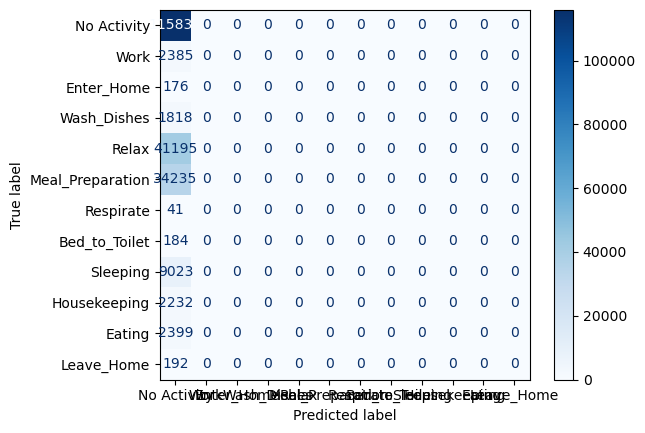

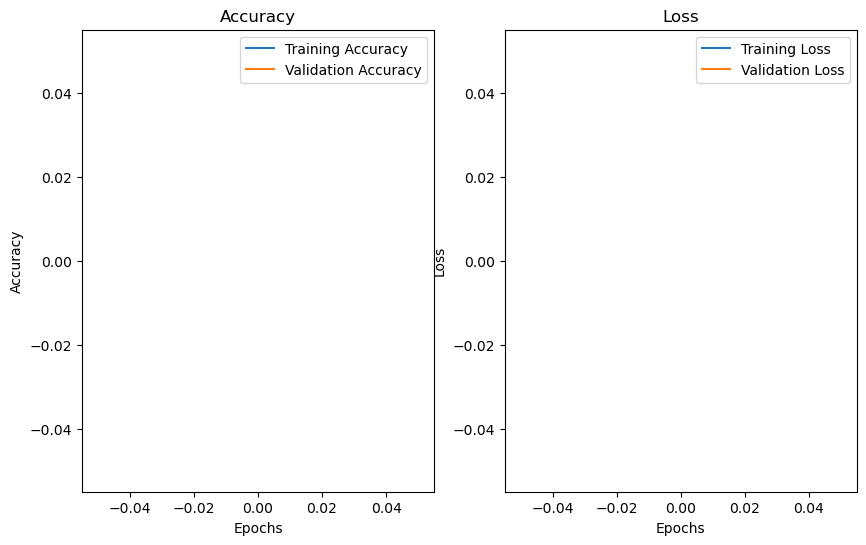

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# تابع پیش‌بینی برای مدل PyTorch
def predict(model, data_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs[0]  # برای TensorDataset
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_preds)

# ایجاد DataLoader برای مجموعه تست
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features_np), batch_size=32, shuffle=False)

# پیش‌بینی برچسب‌ها برای مجموعه تست
y_pred = predict(model, test_loader)
y_pred_classes = y_pred

# چاپ گزارش دسته‌بندی
print("Classification Report:")
print(classification_report(y_val.cpu().numpy(), y_pred_classes, target_names=[index_to_label[idx] for idx in range(num_classes)]))

# محاسبه و رسم ماتریس اغتشاش
conf_matrix = confusion_matrix(y_val.cpu().numpy(), y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[index_to_label[idx] for idx in range(num_classes)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# فرض کنید history را خودتان نگهداری می‌کنید
history = {
    'sparse_categorical_accuracy': [],  # مقادیر دقت آموزشی در اینجا قرار می‌گیرند
    'val_sparse_categorical_accuracy': [],  # مقادیر دقت اعتبارسنجی در اینجا قرار می‌گیرند
    'loss': [],  # مقادیر خطای آموزشی در اینجا قرار می‌گیرند
    'val_loss': []  # مقادیر خطای اعتبارسنجی در اینجا قرار می‌گیرند
}

# این مقادیر را هنگام آموزش در هر epoch به روز رسانی کنید

# رسم نمودار آموزش و اعتبارسنجی
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Final preprocessed data shape: (1048567, 10, 2)
Final labels shape: (1048567,)
Number of unique labels: 12
Sample label mapping: {'Bed_to_Toilet': 0, 'Enter_Home': 1, 'Respirate': 2, 'Eating': 3, 'Wash_Dishes': 4, 'Leave_Home': 5, 'No Activity': 6, 'Relax': 7, 'Housekeeping': 8, 'Work': 9, 'Meal_Preparation': 10, 'Sleeping': 11}
Sample window data:
[[ 1.         -0.29870105]
 [ 0.         -0.29870105]
 [21.5         3.3851779 ]
 [21.          3.3851779 ]
 [21.          3.3851779 ]
 [20.5         3.3851779 ]
 [21.          3.3851779 ]
 [20.5         3.3851779 ]
 [20.          3.3851779 ]
 [21.          3.3851779 ]]
Sample labels:
[11 11 11 11 11]
Epoch [1/2], Loss: 1.3048
Epoch [2/2], Loss: 1.2903
Classifier Epoch [1/2], Loss: 1.4976
Classifier Epoch [2/2], Loss: 1.2905


c:\Users\Ro0ak\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ro0ak\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ro0ak\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                   precision    recall  f1-score   support

   Bed_to_Toilet       0.00      0.00      0.00       184
      Enter_Home       0.00      0.00      0.00       176
       Respirate       0.00      0.00      0.00        41
          Eating       0.00      0.00      0.00      2399
     Wash_Dishes       0.00      0.00      0.00      1818
      Leave_Home       0.00      0.00      0.00       192
     No Activity       0.55      1.00      0.71    115834
           Relax       0.00      0.00      0.00     41195
    Housekeeping       0.00      0.00      0.00      2232
            Work       0.00      0.00      0.00      2385
Meal_Preparation       0.00      0.00      0.00     34235
        Sleeping       0.00      0.00      0.00      9023

        accuracy                           0.55    209714
       macro avg       0.05      0.08      0.06    209714
    weighted avg       0.31      0.55      0.39    209714



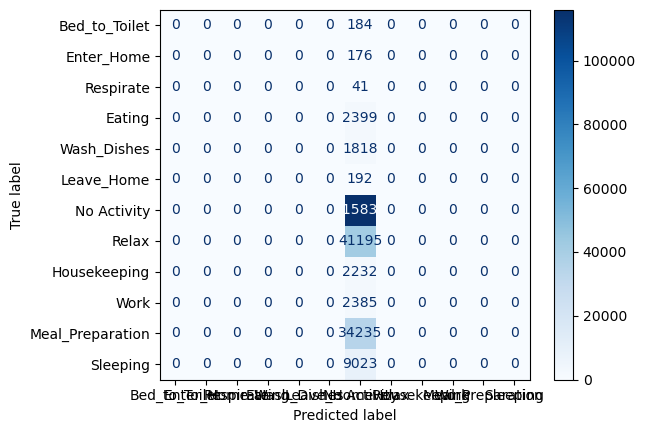

In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
dataset_path = 'C:/Users/Ro0ak/Desktop/dataAruba1.csv'
data = pd.read_csv(dataset_path, delimiter=',', header=None, names=['Date', 'Time', 'Sensor ID', 'State', 'Activity Label', 'Start/End'])

# Preprocess "State" column
def preprocess_state(row):
    sensor_id = row['Sensor ID']
    state = row['State']
    
    if sensor_id.startswith('M') or sensor_id.startswith('D'):
        if state in ['ON', 'OPEN']:
            return 1.0
        elif state in ['OFF', 'CLOSE']:
            return 0.0
    elif sensor_id.startswith('T'):
        try:
            return float(state)
        except ValueError:
            return np.nan
    return np.nan

data['State'] = data.apply(preprocess_state, axis=1)

# Fill missing values for temperature sensors
data['State'] = data.groupby(data['Sensor ID'].str.startswith('T'))['State'].transform(lambda x: x.fillna(x.mean()))

# Fill missing values
data['Activity Label'] = data['Activity Label'].fillna('No Activity')
data['Start/End'] = data['Start/End'].fillna('None')

# Fill "Activity Label" based on "Start/End"
current_activity = 'No Activity'
for index, row in data.iterrows():
    if row['Start/End'] == 'begin':
        current_activity = row['Activity Label']
    elif row['Start/End'] == 'end':
        current_activity = 'No Activity'
    data.at[index, 'Activity Label'] = current_activity

# Preprocess "Sensor ID" column
def preprocess_sensor_id(sensor_id):
    if sensor_id.startswith('M'):
        return 1  # Motion sensor
    elif sensor_id.startswith('D'):
        return 2  # Door sensor
    elif sensor_id.startswith('T'):
        return 3  # Temperature sensor
    else:
        return 0  # Unknown

data['Sensor Numeric ID'] = data['Sensor ID'].apply(preprocess_sensor_id)

# Normalize "Sensor Numeric ID"
scaler = StandardScaler()
data['Sensor Numeric ID'] = scaler.fit_transform(data[['Sensor Numeric ID']])

# Create sliding windows with multiple features
def create_sliding_windows_with_features(data, window_size, step_size):
    windows = []
    labels = []
    features = ['State', 'Sensor Numeric ID']  # Selected features
    
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end][features].values  # Select multiple features
        windows.append(window)
        labels.append(data.iloc[end - 1]['Activity Label'])  # Select activity label
    
    return windows, labels

window_size = 10  # Window size
step_size = 1  # Step size

windows, labels = create_sliding_windows_with_features(data, window_size, step_size)

# Convert windows to PyTorch tensors
window_tensors = [torch.tensor(window, dtype=torch.float32) for window in windows]

# Pad sequences to a fixed length
max_len = max(len(t) for t in window_tensors)
padded_sequences = [F.pad(t, (0, 0, 0, max_len - len(t))) for t in window_tensors]

# Convert tensors to numpy arrays
X = np.stack([t.numpy() for t in padded_sequences])

# Convert labels to integers
label_to_index = {label: idx for idx, label in enumerate(set(labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
y = np.array([label_to_index[label] for label in labels])

# Final data information
print("Final preprocessed data shape:", X.shape)
print("Final labels shape:", y.shape)
print("Number of unique labels:", len(label_to_index))
print("Sample label mapping:", label_to_index)

# Display some samples of windowed data and labels
print(f"Sample window data:\n{X[0]}")
print(f"Sample labels:\n{y[:5]}")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CPC model
class CPCModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CPCModel, self).__init__()
        self.encoder = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.predictor = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        encoded, _ = self.encoder(x)
        output, _ = self.gru(encoded)
        predictions = self.predictor(output)
        return predictions

# Initialize the CPC model
input_dim = X.shape[2]  # Number of features
hidden_dim = 128
output_dim = len(label_to_index)  # Number of unique labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpc_model = CPCModel(input_dim, hidden_dim, output_dim).to(device)

# Define a function to prepare the DataLoader
def prepare_dataloader(X, y, batch_size=64):
    tensor_x = torch.Tensor(X)  # Transform to torch tensor
    tensor_y = torch.Tensor(y).long()
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

train_loader = prepare_dataloader(X_train, y_train)
val_loader = prepare_dataloader(X_val, y_val)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cpc_model.parameters(), lr=1e-4)

# Check for CUDA availability and adjust scaler accordingly
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

# Training loop for CPC model
num_epochs = 2
cpc_model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = cpc_model(batch_x)
                # Reshape outputs and batch_y for CrossEntropyLoss
                batch_size, seq_length, _ = outputs.size()
                outputs = outputs.view(-1, output_dim)  # [batch_size * sequence_length, output_dim]
                batch_y = batch_y.repeat(seq_length)  # Repeat batch_y for each sequence step
                batch_y = batch_y.view(-1)  # [batch_size * sequence_length]

                # Compute the loss
                loss = criterion(outputs, batch_y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = cpc_model(batch_x)
            # Reshape outputs and batch_y for CrossEntropyLoss
            batch_size, seq_length, _ = outputs.size()
            outputs = outputs.view(-1, output_dim)  # [batch_size * sequence_length, output_dim]
            batch_y = batch_y.repeat(seq_length)  # Repeat batch_y for each sequence step
            batch_y = batch_y.view(-1)  # [batch_size * sequence_length]

            # Compute the loss
            loss = criterion(outputs, batch_y)

            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Extract features from CPC model
cpc_model.eval()
features = []
actual_labels = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        predictions = cpc_model(batch_x)
        # Average over the time dimension to reduce dimensions
        features.append(predictions.mean(dim=1).cpu().numpy())
        actual_labels.extend(batch_y.cpu().numpy())

# Convert features to numpy arrays
X_val_features = np.concatenate(features, axis=0)
y_val_labels = np.array(actual_labels)

# Train a simple classifier (e.g., linear classifier) on top of CPC features
classifier = nn.Linear(X_val_features.shape[1], output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

# Training loop for classifier
num_epochs_classifier = 2
batch_size = 64

for epoch in range(num_epochs_classifier):
    permutation = np.random.permutation(X_val_features.shape[0])
    X_val_features_shuffled = X_val_features[permutation]
    y_val_labels_shuffled = y_val_labels[permutation]

    total_loss = 0
    for i in range(0, X_val_features.shape[0], batch_size):
        batch_x = torch.tensor(X_val_features_shuffled[i:i+batch_size], dtype=torch.float32).to(device)
        batch_y = torch.tensor(y_val_labels_shuffled[i:i+batch_size], dtype=torch.long).to(device)
        
        optimizer.zero_grad()
        outputs = classifier(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / (X_val_features.shape[0] // batch_size)
    print(f"Classifier Epoch [{epoch+1}/{num_epochs_classifier}], Loss: {avg_loss:.4f}")

# Evaluation on validation set
classifier.eval()
with torch.no_grad():
    val_outputs = classifier(torch.tensor(X_val_features, dtype=torch.float32).to(device))
    _, predicted_labels = torch.max(val_outputs, 1)
    predicted_labels = predicted_labels.cpu().numpy()

# Classification report and confusion matrix
print("Classification Report:\n", classification_report(y_val_labels, predicted_labels, target_names=index_to_label.values()))

cm = confusion_matrix(y_val_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=index_to_label.values())
disp.plot(cmap=plt.cm.Blues)
plt.show()
